# The Treasure And Shoe Archive from Drehem
## 1. Building the Network

The Treasure and Shoe archive from Drehem (ancient Puzriš-Dagan) is a relatively small archive (< 300 documents) of administrative texts that date to the 21st century BCE and deal with valuable objects (made of metals and valuable stones) and leather objects (shoes and belts, etc.). The archive was studied in detail by Paola Paoletti in her book *Der König und sein Kreis* (2012). The present notebook essentially takes the texts edited and studied by Paoletti, assigning roles to personal names in each text and creating edges between actors in the documents. By identifying nodes (people) and edges (connections between people) this notebook creates a social network that may be analyzed with the tools of Social Network Analysis.

The present notebook will create the social network and do some initial plotting. The next notebook will focus on the analysis of the network.

This notebook goes through several steps: 
* Data acquisition
* Data cleaning
* Defining Nodes
* Assigning roles
* Defining edges
* Creating a Network (using networkx)

We will pay much attention to checking the validity of the results. At every stage (identifying nodes, identifying edges, and creating the network) there will be the possibility to see the outcome for one single text with a link to the edition of that text.

Although the treasure archive uses very standardized terminology (keywords), it is not always possible to determine nodes and edges programmatically. We therefore include the option to list the edges by hand in a Comma Separated Values file and add those to the edges that were found computationally.

Many of the keywords that determine the roles of actors in Treasury texts are also used in other Puzriš-Dagan files. The structure of the code is such that other archives may be analyzed essentially the same way.

## 1.0 Import the Necessary Modules
Here we import the modules necessary for data acquisition and data cleaning and for assignment of roles and edges.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # this suppresses a warning about pandas from tqdmimport pandas as pd
import os
import sys
import zipfile
import json
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()
from ipywidgets import interact
import ipywidgets as widgets
from ipywidgets import Layout
import webbrowser    # for opening web pages
import networkx as nx
import networkx.algorithms.community as nxcom
%matplotlib inline
from IPython.display import display, clear_output
import re
import pickle
util_dir = os.path.abspath('../utils')
sys.path.append(util_dir)
from utils import *

## 1.1 The Corpus

A list of P numbers (text ID numbers) of texts that belong to the Treasure/Shoe archive is available in the directory `csv`, kindly made available by Paolo Paoletti. This list contains some additional information, for instance where a text was published, and to which sub-archive it belongs. The latter information may be used later on to separate the Treasure texts from the leather texts (or to color those differently in a plot).

One of the texts studied in her book still remains unpublished and is therefore not included (this is U.30117). Several additional Treasury texts were published by [Nawalla Al-Mutawalli and Walther Sallaberger 2018](https://doi-org.libproxy.berkeley.edu/10.1515/za-2017-0101) and one additional leather text is found in [RSO 83 (2010), 345 text 14](http://oracc.org/epsd2/admin/ur3/P433582). Another leather text was identified among the photographs of texts from the Louvre ([AO 11393](http://oracc.org/epsd2/admin/ur3/P493329)) made available on [CDLI](http://cli.ucla.edu/P493329).

The corpus used here is, therefore, not exactly identical to what was used in Paoletti's book - but it is very close. At the moment of writing the corpus that is being used includes 298 documents.

In [2]:
file = 'csv/treasury_shoes2.txt'
tr_df = pd.read_csv(file, encoding='utf8')
ids = list(tr_df['id_text'])
ids.sort()

### 1.1.0 Downloading the Corpus
When running this notebook for the first time (or after a major update of the Ur III corpus on [epsd2])(http://oracc.org/epsd2/admin/ur3) it is necessary to download the entire Ur III corpus in JSON format. If you already have the file `epsd2-admin-ur3.zip` in the `jsonzip` directory you may comment out the command that does the download, by placing a hashmark (#) in front of it as follows: 

``` python
#oracc_download([project])
```

Remove the hashmark and run the cell again to download a fresh copy (this is a large file and may take between one and ten minutes, depending on the speed of your computer and your connection).

# Note
Instead of the full Ur III corpus, we are using the (temporary) ORACC project [treasury](http://build-oracc.museum.upenn.edu/treasury/pager), which contains all of the documents that belong to our corpus. In order to maintain compatability with other usages of this script with other corpora, the code that selects the relevant documents is maintained.

In [3]:
project = 'treasury'
#project = 'epsd2/admin/ur3'
oracc_download([project]);

Saving http://build-oracc.museum.upenn.edu/json/treasury.zip as jsonzip/treasury.zip.


### 1.1.1 The Parsejson function

The `parsejson()` function used here differs in one way from the ones demonstrated in Chapter 2.1. The code looks for a `key` called `ftype` (field type) among the lemmatization data. The only value that `ftype` may take in this corpus is `yn`, indicating that a word is part of a year name. The field `ftype` enables us to easily exclude year names from our analysis. We will, of course, consider the dating of each text (that is part of the metadata). The vocabulary of the year names, however, is irrelevant for understanding the transactions and connections described in this corpus.

In [4]:
def parsejson(text):
    for JSONobject in text["cdl"]:
        if "cdl" in JSONobject: 
            parsejson(JSONobject)
        if "label" in JSONobject:
            meta_d["label"] = JSONobject['label']
        if "f" in JSONobject:
            lemma = JSONobject["f"]
            if "ftype" in JSONobject:
                lemma['ftype'] = JSONobject['ftype'] # this picks up YN for year name
            lemma["id_word"] = JSONobject["ref"]
            lemma['label'] = meta_d["label"]
            lemma["id_text"] = meta_d["id_text"]
            lemm_l.append(lemma)
        if "strict" in JSONobject and JSONobject["strict"] == "1":
            lemma = {key: JSONobject[key] for key in dollar_keys}
            lemma["id_word"] = JSONobject["ref"]
            lemma["id_text"] = meta_d["id_text"]
            lemm_l.append(lemma)
    return

### 1.1.2 Call the Parser on Treasury Texts

The variable `ids`, created above, holds all the P numbers of the documents we are interested in. This list is used to define the list of files to be extracted from the `zip` file and to be sent to the parser. Otherwise, the code below is identical to the code in Chapter 2.1.

In [5]:
lemm_l = []
meta_d = {"label": None, "id_text": None}
dollar_keys = ["extent", "scope", "state"]
file = f"jsonzip/{project.replace('/', '-')}.zip"
try:
    z = zipfile.ZipFile(file) 
except:
    print(f"{file} does not exist or is not a proper ZIP file")
files = z.namelist() # list of all the files in the ZIP file
files = [name for name in files if name[-12:-5] in ids] # select only those of the treasury/leather archive
for filename in tqdm(files, desc = project):
    id_text = project + filename[-13:-5] 
    meta_d["id_text"] = id_text
    try:
        st = z.read(filename).decode('utf-8')
        data_json = json.loads(st)           
        parsejson(data_json)
    except:
        print(f'{id_text} is not available or not complete')
z.close()

### 1.1.3 DataFrame

The `parsejson()` function has filled the list of lists `lemm_l` with data. This list  is read into a DataFrame for further manipulation. We remove commas and spaces from Guide Words and simplify the field `id_text` to read "P433582" instead of "epsd2/admin/ur3/P433582" (all documents derive from [epsd2/admin/ur3](http://oracc.org/epsd2/admin/ur3)).

Finally the code adds a field `id_line` (integer) in order to keep track of the lines in a document. Since lines are meaningful units in Sumerian administrative texts, this will be an important tool. 

All of these steps are identical (or very similar) to steps explained in Chapter 2.1.

In [6]:
words = pd.DataFrame(lemm_l).fillna('')
keep = ['extent', 'scope', 'state', 'id_word', 'id_text', 'form', 'cf', 'gw', 'pos', 'ftype', 'label']
words = words[keep]
words['gw'] = words['gw'].replace([' ', ','], ['', ''], regex=True)
words['id_text'] = [i[-7:] for i in words['id_text']]
words['id_line'] = [int(i.split('.')[1]) for i in words['id_word']]

### 1.1.4 Creating a Lemma Field

The `lemma` field strings Citation Form, Guide Word, and Part of Speech together and is dealt with in the same way as in Chapter 2.1 Words that remain unlemmatized (e.g. because of illegible or broken signs) are represented by their `form` (transliteration) and numbers receive the POS 'NU'. 

In the DataFrame (physical) breaks and text divisions (marked by horizontal rulings on the tablet, blank lines, and the like) are preserved in the field `state`. Such demarcations have their own row in the DataFrame and receive their own line ID, but they do not have data in fields such as `form`. In order to keep track of breaks we will define two different types: logical and physical breaks. The keywords break_physical and break_logical are included in the `lemma` column. 

In [7]:
physical_break = ['illegible', 'traces', 'missing', 'effaced']
logical_break = ['other', 'blank', 'ruling']
words['lemma'] = words["cf"] + '[' + words["gw"] + ']' + words["pos"]
words.loc[words["cf"] == "" , 'lemma'] = words['form'] + '[NA]NA'
words.loc[words["pos"] == "n" , 'lemma'] = words['form'] + '[]NU'
words.loc[words["state"].isin(logical_break), 'lemma'] = "break_logical"
words.loc[words["state"].isin(physical_break), 'lemma'] = "break_physical"
words.head(10)

,extent,scope,state,id_word,id_text,form,cf,gw,pos,ftype,label,id_line,lemma
0,,,,P144254.3.1,P144254,5(diš),,,n,,o 1,3,5(diš)[]NU
1,,,,P144254.3.2,P144254,ma-na,mana,unit,N,,o 1,3,mana[unit]N
2,,,,P144254.3.3,P144254,ku₃-babbar,kugbabbar,silver,N,,o 1,3,kugbabbar[silver]N
3,,,,P144254.4.1,P144254,la₂-ia₃,laʾu,arrears,N,,o 2,4,laʾu[arrears]N
4,,,,P144254.4.2,P144254,su-ga,sug,replace,V/t,,o 2,4,sug[replace]V/t
5,,,,P144254.4.3,P144254,unu₃-e-ne,unud,cowherd,N,,o 2,4,unud[cowherd]N
6,,,,P144254.5.1,P144254,e₂,e,house,N,,o 3,5,e[house]N
7,,,,P144254.5.2,P144254,kurušda,kurušda,fattener,N,,o 3,5,kurušda[fattener]N
8,,,,P144254.6.1,P144254,ki,ki,place,N,,o 4,6,ki[place]N
9,,,,P144254.6.2,P144254,{d}šara₂-kam,šara₂,00,PN,,o 4,6,šara₂[00]PN


## 1.2 Proper Nouns in the Ur III Corpus
### 1.2.0 The Name Authority

In order to build a network of interactions between individuals in the Treasury corpus we need to be able to extract proper nouns. The lemmatization of proper nouns in the Ur III corpus is still in early stages, so that we cannot fully rely on the lemmatized data as represented in our DataFrame. A list of all proper nouns from Drehem texts was put together by John Carnahan and Niek Veldhuis, based on the Drehem texts in [BDTNS](http://bdtns.filol.csic.es/), December 2016. This list includes the form of each name (in transliteration) plus a normalization of that name in [epsd2](http://oracc.org/epsd2) style. The list includes spelling variants as well as names with morphology. Thus, **Ur-{d}en-lil₂**, **Ur-{d}en-lil₂-la₂**, and **Ur-{d}en-lil₂-la₂-ta** are all listed seperately, and are all associated with the same name, as follows: 
```csv
Ur-{d}En-lil₂,UrEnlilak[]PN,
Ur-{d}En-lil₂-la₂,UrEnlilak[]PN,
Ur-{d}En-lil₂-la₂-še₃,UrEnlilak[]PN,
Ur-{d}En-lil₂-la₂-ka-še₃,UrEnlilak[]PN,
Ur-{d}En-lil₂-la₂-ka-ta,UrEnlilak[]PN,
Ur-{d}En-lil₂-la₂-ke₄,UrEnlilak[]PN,
Ur-{d}En-lil₂-la₂-ta,UrEnlilak[]PN,
Ur-{d}En-lil₂-ta,UrEnlilak[]PN,
```
Similarly, name instances that have different spellings but belong to the same underlying name are associated with one normalized form of that name, as in: 
```csv
{d}Šul-gi-si-im-ti,Šulgisimti[]PN, 
{d}Šul-gi-si-im-tum,Šulgisimti[]PN,
```

The list includes all name forms from Drehem (in 2016), currently almost 6,000 entries. 

We will use this list (`drehem_names2.csv`, available in the `Normalized` directory) to find proper nouns (Personal Names, Divine Names, Geographical Names, etc.) in our DataFrame and to create more reliable lemmatizations of names than [epsd2](http://oracc.org/epsd2) can offer today.

In [8]:
normdf = pd.read_csv('Normalized/drehem_names2.csv', encoding='utf8')
normdf

,transliteration,normalization,sign_names,remarks
0,A-AN-ba-az,A.AN.ba.az[]PN,A AN BA |PIRIG×ZA|,MVN 13 464 r 10 (copy/photo)
1,A-KU-um,A.KU.um[]PN,A KU UM,"Aegyptus 10, 270 27 o 7 (copy)"
2,A-KU.KU-ta,A.KU.KU[]PN,A KU KU TA,AnOr 12 277 o i 17' (copy)
3,A-NI-ta,A.NI[]PN,A NI TA,Babyl. 7 pl. 22 18 o 3 (copy)
4,A-U.E₂-nu-tuku,A.U.E₂.nu.tuku[]PN,A U E₂ NU TUK,AnOr 07 150 o 2: A-U.KID-nu-tuku IŠ (copy/photo)
...,...,...,...,...
5801,{d}utu,Utu[]DN,AN UD,
5802,{d}utu-bar-ra,Utubara[]DN,AN UD BAR RA,
5803,Ma₂-gur₈-mah,Magurmah[]ON,MA₂ TE@G MAH,
5804,Ma₂-dara₃-abzu,Madaraʾabzu[]ON,MA₂ DARA₃ ZU AB,


### 1.2.1 Reduce Names to Sign Sequences

Many Proper Nouns may validly be transcribed in different ways. Sometimes that is the case because the name is not fully understood or of foreign origin. The city name **a-dam-DUN{ki}** is read variously **a-dam-šah₂{ki}**, **a-dam-dun{ki}**, or **a-dam-DUN{ki}** by different scholars. For a network, the correct reading is of less importance than a consistent reading. All these readings reflect a sign sequence **A DAM DUN KI**, a sequence of signs that cannot plausibly be anything else than a reference to this city.

We will, therefore, use the ORACC Global Sign List ([ogsl](http://oracc.org/ogsl)) to transform each name form in our data set into a sequence of signs. The name authority already has a column `sign_names`; we can  use this column to associate sign sequences with normalized names.

Much of the code in the following cells is equivalent to code in Chapter 2.4, where we developed a tool for searching signs in [bdtns](http://bdtns.filol.csic.es/) data.

### Download OGSL

Using code developed in Chapter 2, download the file `ogsl.zip`, which contains all of the [OGSL](http://oracc.org/ogsl) data (sign names and sign readings) in JSON format.

In [9]:
oracc_download(['ogsl']);

Saving http://build-oracc.museum.upenn.edu/json/ogsl.zip as jsonzip/ogsl.zip.


#### 1.2.1.0 Sign Equivalencies

In the Ur III period, some signs that are differentiated in [OGSL](http://oracc.org/ogsl) have coincided. For instance, **DUR₂** and **KU**, which are separate in the Fara period, are represented by the same sign in Ur III. Such signs are listed in the following dictionary. This list may not be complete - it can be extended when additional equivalencies are identified. The compiled [regular expression](https://docs.python.org/3/howto/regex.html) is used to replace sign names where appropriate while parsing the [OGSL](http://oracc.org/ogsl) JSON in the next cell.

In [10]:
equiv = {'ANŠE' : 'GIR₃', 
        'DUR₂' : 'KU', 
        'NAM₂' : 'TUG₂', 
        'TIL' : 'BAD', 
        'NI₂' : 'IM',
        'ŠAR₂' : 'HI', 
         'DUH' : 'GABA'
        }
w = re.compile(r'\w+') # replace whole words only - do not replace TILLA with BADLA.
           # but do replace |SAL.ANŠE| with |SAL.GIR₃|

#### 1.2.1.1 Parse OGSL
The parse function uses the `equiv` dictionary and the compiled regular expression to fill a dictionary, associating each valid sign reading with a sign name.

In [11]:
def parseogsljson(data_json):
    for key, value in data_json["signs"].items():
        key = re.sub(w, lambda m: equiv.get(m.group(), m.group()), key)
        if "values" in value:
            for n in value["values"]:
                d2[n] = key
    return

#### 1.2.1.2 Call the OGSL parser
Calling  the function in the previous cell, a dictionary is formed where each `key` is a sign value and each `value` a sign name.

In [12]:
d2 = {}  # this empty dictionary is filled by the parsejson() function, called in this cell.
file = "jsonzip/ogsl.zip"
z = zipfile.ZipFile(file) 
filename = "ogsl/ogsl-sl.json"
signlist = z.read(filename).decode('utf-8')
data_json = json.loads(signlist)                # make it into a json object (essentially a dictionary)
parseogsljson(data_json)  
with open('output/ogsl_dict.p', 'wb') as p:
    pickle.dump(d2, p)  

#### 1.2.1.3 Transliteration to Sign Sequence

In [13]:
separators = ['{', '}', '-']
separators2 = ['.', '+', '|']  # used in compound signs
#operators = ['&', '%', '@', '×']
flags = "][?<>⸢⸣⌈⌉*/" # note that ! is omitted from flags, because it is dealt with separately
table = str.maketrans(dict.fromkeys(flags))

In [14]:
def signnames(translit):  
    """This function takes a string of transliterated cuneiform text and translates that string into a string of
    sign names, separated by spaces. In order to work it needs the variables separators, separators2, flags, and table defined above. The variable table
    is used by the translate() method to translate all flags (except for !) to None. The function also needs a dictionary, called d2, that has as
    keys sign readings and sign names as corresponding values. In case a key is not found, the sign reading is replaced by itself."""
    sign_sequence = []
    translit = translit.translate(table).lower()  # remove flags, half brackets, square brackets.
    translit = translit.replace('...', 'x')
    for s in separators: # split transliterated form into signs   
        translit = translit.replace(s, ' ').strip()
    s_l = translit.split() # s_l is a list that contains the sequence of transliterated signs without separators or flags
    # Now take care of some special situations: signs with qualifiers, compound signs.
    for sign in s_l:
        if '!' in sign: # corrected sign, as in ka!(SAG), get only the corrected reading.
            sign = sign.split('!(')[0]
            sign = sign.replace('!', '') # remove remaining exclamation marks
        elif sign[-1] == ')' and '(' in sign: # qualified sign, as in ziₓ(SIG₇) - get only the qualifier
            sign = sign.split('(')[1][:-1]
        sign_sequence.append(sign)
    sign_sequence = [d2.get(sign, sign).upper() for sign in sign_sequence] # replace each transliterated sign with its sign name.
    signnames = ''
    for s in sign_sequence:
        if '.' in s or '+' in s: # DIRI signs are analyzed only when they represented a simple sign sequence
            if not '×' in s: # compounds like |UD×(U.U.U)| are not further analyzed.
                for sep in separators2:
                    s = s.replace(sep, ' ').strip() 
        signnames = f'{signnames} {s}'.strip()
    return signnames

#### 1.2.1.4 Create a Column Sign_Names
Use the function in the cell above to add a new column column, called `sign_names`, to the `words` DataFrame.

In [15]:
words['sign_names'] = words['form'].progress_map(signnames)

##### 1.2.1.5 Proper Noun Dictionary
Transform the Name Authority into a dictionary with `sign_names` as key and `normalization` as value and use this dictionary to transform words marked as Proper Nouns or 'X' (unknown) in the Part of Speech (`pos`) column into normalized names.

In [16]:
proper_nouns = ['RN', 'PN', 'DN', 'AN', 'WN', 'ON', 'TN', 'CN', 'GN', 'SN']
normd2 = dict(zip(normdf['sign_names'], normdf['normalization']))
words.loc[words.pos.isin(proper_nouns + ['X']), 'lemma'] = words.progress_apply(lambda x: normd2.get(x['sign_names'], x['lemma']), axis=1)

#### 1.2.1.6 Apply Corrections
The Ur III data sets as represented in [epsd2/admin/ur3](http://oracc.org/epsd2/admin/ur3) may still contain errors, which will  surface later in the process. For instance, a name does not show up in the analysis, because it has not been lemmatized as a name. Or, the other way around, a word may have been falsely lemmatized as a name. When found, such errors can be corrected (temporarily, until they get corrected in the source files) in the file `corrections.csv` in the directory `Normalized`, associating forms with correct lemmatizations. The final line of code in this cell will correct the column `pos` when necessary.

In [17]:
#corrections = pd.read_csv('Normalized/corrections.csv', encoding='utf8')
#corr_d = dict(zip(corrections['form'], corrections['corr']))
#words.loc[words.pos.isin(proper_nouns + ['X']), 'lemma'] = words.progress_apply(lambda x: corr_d.get(x['form'], x['lemma']), axis =1)
words['pos'] = [w.split(']')[-1] if ']' in w else '' for w in words['lemma']]

## 1.3 Nodes and Roles
### 1.3.0 Document Typology
**This cell should be moved to the Roles section, where the typology is used**

Different types of documents will be treated differently. In the Treasure Archive the main document types are Intake, Expenditure, and Transfer.

|  type           | keyword         | lemma(s)              | description |
|----------------|------------------|-----------------------|-------------|
| Intake      | mu-kuₓ(DU)      | mu.DU\[delivery\]N      | materials delivered to the administration |
| Expenditure | ba-zi or zi-ga  | zig[rise]V/i          | materials expended by the administration |
| Transfer    | šu ba-ti        | šu\[hand\]N teŋ\[near\]V/i | materials transfered from one office to another |

In the great majority of cases they can be identified simply by looking  for the keyword lemmas.

This typology is discussed in much detail in Paoletti's *Der König und sein Kreis* (2012), Chapter 2.1 and 3.1.

In [18]:
texttype = []
for i in ids:
    ttype = ''
    text = list(words.loc[words.id_text == i, 'lemma'])
    if 'mu.DU[delivery]N' in text:
        ttype = 'intake'
    elif 'zig[rise]V/i' in text:
        ttype = 'expenditure'
    elif 'teŋ[near]V/i' in text: 
        ttype = 'transfer'
    texttype.append(ttype)
treasure = dict(zip(ids, texttype))

### 1.3.1 Harvest Nodes

For the node list, select Personal Names (PN) and Royal Names (RN) but skip those that appear in Year Names or Seals. Add lugal (king) sukkalmah (prime minister) and nin (queen), because these actors may be mentioned without personal name. Seals and year names are excluded here because the text of a seal or a year name does not directly reflect the transaction that is recorded in the tablet. Seals do include important information about the identity of the sealer (a father's name, a profession and/or loyalty to a king or another high official). Such information could be harvested for node attributes (but that is not done here). Year names include essential chronological information (and that is taken care of elsewhere) - but the proper nouns in year names (the name of the king, or the name of a priest being elected) are not part of the transaction proper.

In [19]:
unnamed = {'lugal[king]N', 'nin[queen]N', 'sukkalmah[official]N'}
names = set(words.loc[words.pos.isin(['PN', 'RN', 'DN']), 'lemma'])
actors = unnamed | names
seal = list(words.loc[words.label.str.contains('seal'), 'id_word'])
yn = list(words.loc[words.ftype == 'yn', 'id_word'])
exclude = seal + yn
PNs = words.loc[(words.lemma.isin(actors)) & (~words.id_word.isin(exclude))].copy()

#### 1.3.2 Define keywords and the corresponding roles
The accounts use key words to indicate the particular role of each person in a document. Some of these key words (or key phrases, in some instances) follow the Proper Noun, others precede it. Thus when the word **ŋiri\[foot\]N** immediately precedes a Personal Name, that person is an intermediary (or conveyor). A Personal Name followed by **šu\[hand\]N teŋ\[near\]V/i** marks the recipient of goods.

The keywords are associated with a role in two separate dictionaries.

In [20]:
key_post = {'mu.DU[delivery]N': 'deliverer', 'maškim[administrator]N' : 'representative', 
               'zig[rise]V/i' : 'expender',
               'šu[hand]N teŋ[near]V/i': 'recipient' , 'šu[hand]N us[follow]V/t': 'sender', 
           'la[hang]V/t' : 'weigher'
            }
key_pre =  {'ŋiri[foot]N' : 'conveyor', 
            'arua[offering]N' : 'offerer', 'kišib[seal]N' : 'sealer', 
            'gabari[copy]N kišib[seal]N' : 'sealer', 'mu.DU[delivery]N' : 'deliverer',
            'mu[name]N' : 'reason', 'ki[place]N' : 'source', 'kiŋ[work]N ak[do]V/t' : 'producer', 
            'niŋgur[property]N' :'owner', 'šag[heart]N la[hang]V/t' : 'weigher'}

### 1.3.3 Determine the Role of each PN
The role of a personal name in an administrative texts is determined by keywords before of after the name. The keywords and their corresponding roles are defined in the dictionaries `key_post` and `key_pre` in the preceding cell.

The DataFrame `PNs`, created above, is an extract from the DataFrame `words` and therefore uses the same indexes. If the index of a Personal Name in `PNs` is `i`, then the word before that name is `words.loc[i-1]`.

We iterate over the index numbers in `PNs` to determine which keywords are found before or after. Before doing so we determine the extent of a document by finding the lowest and highest index number with the same `id_text` as the name instance we are dealing with. Similarly, we can define the extent of the line on which the name is found by finding the lowest and highest index number of the words within the document that share the same `id_line`. With these index numbers we can easily see whether a name is in first position in a line (its index equals the lowest index of that line) or what the last word is in the line in which the name instance appears. We can also check to make sure that when we inspect the next line, this line still belongs to the same document. Working with indexes this way is very fast and flexible - we do not have to look up the P number (in `id_text`) every time, or check the `id_line` field.

Because of the structure of Sumerian grammar, keywords that come *after* the name may be separated from their name instance by one or more positions, as in:
> 	ARAD₂-{d}nanna sukkal maškim			AradNanna the prime minister was representative." 

In practice the keyword is always the last word on the line, or the first on the next line, as in:
> 	lu₂-{d}nanna šagina nag-su{ki}-ke₄ 		LuNanna the military leader of Nagsu
> 	šu ba-ti 								received

Therefore, if the PN is the first word on the line, we can check  to see if the last word on the line is a keyword and, if so, assign a role to the PN. We can also look at the first word (or two words) of the next line, to see if there is a keyword in that position. Any word following the PN that is not a keyword is considered an attribute (a father's name, a profession, etc.).

If the PN is not the first word on the line (its index number is higher than the lowest index number of that line), one possibility is that it is preceded by a keyword, as in:
> 	ki lu₂-dingir-ra-ta					from Ludingira

If there is a preceding keyword, we use the `key_pre` dictionary to assign a role. But a PN later in the line may also be the name of a parent (PN1 dumu PN2) or some other relative, or, occasionally, the name of an employer, as in:
> 	giri₃ a-bu-du₁₀ lu₂ a-bu-ni-ka		Conveyor: Abuṭāb the man of Abuni

In the case of Abuni, his name is not preceded by a keyword, but there is another PN earlier in the line. Abuni does not have a role in the document directly, but he is involved indirectly by his relation of authority to Abuṭāb. In such cases the role is defined as 'relation'. 

If none of these methods results in a role assignment, we fall back to default roles. Default roles are different for different document types. Transfer texts (keywords šu ba-ti) and Intake (mu.DU\[delivery\]N) may record deliveries by multiple people who are not specifically marked with a keyword. The default in those texts is "source". Expenditure texts (zi-ga or ba-zi) may record expenditures to various people, not marked specifically. Here the default is "recipient".

The code takes care of a few special cases. If a name is preceded by u\[and\]CNJ the role of that name is the same as the role of the preceding name. The expression ki PN-še₃ ("to the place of") appears a few times in this archive, but is otherwise very rare in Ur III. It uses the same keyword ki\[place\]N as the very common expression ki PN-ta ("from the place of") but has the opposite meaning. Since the morphology (-ta vs. -še₃) is not available in the `lemma` column, we have to use the `form` column to check for such instances. The expression kin ak, which precedes the name of a craftsman (finished work of ...) may be found on the line preceding the name.

Breaks in the text and horizontal rulings have their own entries in the DataFrame `words`, with separate index numbers and a separate `id_line`. This means that while looking for keywords in a preceding or following line the code will never "jump" over such a break. If, for instance, a document has a name instance right before a break and the line right after the break has šu ba-ti, this will not result in the role "recipient" for the name instance because the break is the next line. It is possible that a name instance right before or right after a break does not receive a role because key words are missing - and is then assigned a default role. This is a possible source of errors.

Much of the code here might be used in the same way for other Ur III archives, but it is likely that there will be other keywords and other special cases that one would need to take care of.

In [21]:
role = []
attribute = []
for i in PNs.index:                           # the index of PNs is identical to the one of words
    Pno = PNs.loc[i]['id_text']                    # the text ID (P number)
    lineno = PNs.loc[i]['id_line']                 # the line number in which the name instance appears
    text = words.loc[words.id_text == Pno]                # the entire text
    line = text.loc[text.id_line == lineno] #  the line with the PN
    mnw = min(line.index)                 # index no. of first word in line
    mxw = max(line.index)                   # index no. of last word in line
    mn = min(text.index)                    # index no. of first word in text
    mx = max(text.index)                    # index no. of last word in text
    mxl = text.loc[mx]['id_line']          # highest line number in text
    if lineno < mxl:                       # check that next line is still in the same text
        nl = text.loc[mxw + 1, 'id_line']  # line id of the word after 
                                           # the last word of the line
        nextline = text.loc[text.id_line == nl] # words in nextline
    else:
        nextline = pd.DataFrame(columns = words.columns) #empty dataframe
    attr = []
    r = ''
    # first get attributes
    if i < mxw:  # PN is not the last word of the line
        attr = list(line.loc[i+1:]['lemma'])   # all words following a PN are attributes
        attr = [w for w in attr if not w in key_post]  # except for keywords
        if len(attr) > 1: 
            if ' '.join(attr[-2:]) in key_post: # or multi-word keywords
                attr = attr[:-2]
                
    # now assign roles
    if mnw == i:               # PN in first position
        r = key_post.get(line.loc[mxw]['lemma'], r)    # keyword appears in same line in last position
        r = key_post.get(words.loc[mxw+1]['lemma'], r) # or in the next line in first position
        if len(line) > 1: 
            lastwords = ' '.join(list(line[-2:]['lemma'])) # two-word keywords (as in šu ba-ti)
            r = key_post.get(lastwords, r)
        if len(nextline) > 1:               # two-word keyword appearing in first position in next line
            firstwords = ' '.join(list(nextline[:2]['lemma']))
            r = key_post.get(firstwords, r) 
        if i > mn + 1:  # special case: if kin ak or ša₃ i₃-la₂ is found on preceding line 
            preceding2words = ' '.join(list(words.loc[i-2:i-1]['lemma']))
            r = key_pre.get(preceding2words, r)

                
    elif i > mnw:             # PN appears further in the line with keyword(s) preceding
        firstwords = ' '.join(list(line.loc[mnw:i-1]['lemma']))  # join all words before PN
        r = key_pre.get(firstwords, r)        # ŋiri₃ PN; ki PN-ta; kin ak PN; etc
        if line.loc[mnw]['lemma'] == 'ki[place]N' and line.loc[mxw]['form'].endswith('-še₃'): 
            r = 'destination'              # special case: ki PN-še₃         
        if r == '':                # role has not been filled yet
            PN = [w for w in line.loc[mnw:i-2]['lemma'] if w in list(PNs['lemma'])] # is there another PN previously in the line?
            if PN:                                                                  
                if words.loc[i-1]['lemma'] == 'u[and]CNJ':   # PN1 u PN2
                    if role:
                        r = role[-1]               # same role as previous PN
                else:
                    r = 'relation'             # as in PN dumu PN
            elif treasure.get(Pno) == 'expenditure': # commodities + PN: recipient
                r = 'recipient'
            else:                              # if there is no preceding PN: drop the name
                r = 'none'                     # this may  need refinement
        if PNs.loc[i]['lemma'] in unnamed and words.loc[i-1]['lemma'] in list(PNs['lemma']):  
            r = 'none'       # 'unnamed' person (e.g. sukkalmah) is preceded by name
    if r == '' :
        if treasure.get(Pno) == 'expenditure': # default role for zi-ga/ba-zi texts
            r = 'recipient'
        elif treasure.get(Pno) in ['intake', 'transfer']:    # default role for mu-DU and šu ba-ti texts
            r = 'source'
    role.append(r)
    attribute.append(' '.join(attr))
PNs['role'] = role
PNs['attribute'] = attribute

### 1.3.4 Show results in a table with links for checking
The code in the following two cells does not add or change anything, but allows to check the results. One may inspect the entire output, or restrict it to a certain type of role, or one particular text.

The Pandas `style` method creates links out of properly formated HTML anchor (\<a\>) tags. The links are made by adding the `id_word` field to the URL for the treasury database. This will highlight the word in question. Note that `id_word` is fairly stable, but not absolutely so. If the text has been edited in such a way that there are more (or less) lines on the object or there are more (or less) words in the line, the highlighting may be off.

Move the slide to see more (or less) results.

In [22]:
anchor = '<a href="http://build-oracc.museum.upenn.edu/treasury/{}", target="_blank">{}</a>'
PNs2 = PNs[['id_word', 'form', 'pos', 'lemma', 'role', 'attribute']].copy()
PNs2['id_word'] = [anchor.format(val,val) for val in PNs['id_word']]
roles = PNs.role.unique()
roles.sort()

In [23]:
@interact(rows = (1, len(PNs2), 1), textid = [''] + ids,role=roles)
def showpns(rows = 25, textid = '', role=''):
    if textid == '' and role == '': 
        return PNs2[:rows].style
    elif textid == '': 
        return PNs2[PNs.role == role][:rows].style
    elif role == '': 
        return PNs2[PNs.id_text == textid][:rows].style
    else: 
        return PNs2[(PNs.role == role) & (PNs.id_text == textid)][:rows].style

interactive(children=(IntSlider(value=25, description='rows', max=1110, min=1), Dropdown(description='textid',…

## 1.4 Create Edges
In order to create edges we need to decide what the direction is of the movement. For instance, goods go from a 'source' to a 'conveyor' and from there to a 'recipient'. This example creates two edges: 
> source => conveyor </br>
> conveyor => recipient

Each edge is a separate row in a new dataframe, whith four columns: `source`, `target`, `id_text`, and `edgetype`.

In order to create an edge we find a name, check its role, and then look for a name with an appropriate role further on in the text. In an Intake document, if we find an `conveyor` (keyword ŋiri₃) we want to find a matching `recipient` (šu ba-ti) - this will be the first PN with role `recipient` after our `conveyor`. If we find a `recipient` we want to find a matching `expender` later in the text. In an Intake document we will not find one, because the `recipient`is found at the end with the keywords šu ba-ti (that edge has already been made when the `source` or the `conveyor` was encountered earlier in the text). In Expenditure documents, however, a list of recipients comes first, each one potentially followed by a `repesentative` or `conveyor` with an `expender` at the end. By  searching only forwards we avoid making double edges.

This way we can take care of multiple transaction texts, where we may have multiple pairs of "source" and "conveyor" (or "representative") and one "recipient" at the end, or multiple "recipients" followed by one "expender".

The one exception is for the role "relation" in a line like: 
> 	giri₃ a-bu-du₁₀ lu₂ a-bu-ni-ka		Transporter: Abuṭāb the man of Abuni

Here, Abuni has the role 'relation', which always points backwards in the document. The "relation" (here: Abuni) is the Source, and the first name encountered before this one is the Target (here Abuṭāb), whatever its role. Since, in this case, Abuṭāb has the role "conveyor" he will have three edges ([Trouvaille 86](http://oracc.org/epsd2/admin/ur3/P134759)):

 | source | target |
 |--------|-----------|
 | Abuni  | Abuṭāb |
 |Šu-Enlil | Abuṭāb |
 |Abuṭāb | PuzurErra |
 
 Šu-Enlil, who sends his goods through Abuṭāb to PuzurErra, is qualified himself as "son"of the king", so that he, in turn, will appear in  another edge in which the king is Source, and Šu-Enlil Target.
 
 These edges are of different kinds. By default all edges are of the type "transaction", except for those that express a relationship (familial or otherwise); those are marked as "relation".

In [24]:
edges = []
for Pno in ids:                              # one document ID at a time
    people = PNs.index[PNs.id_text == Pno]    # indexes of all the people in that document
    for p in people:                       # iterate over those indexes
        rest = PNs.loc[p+1 : max(people)].index # indexes of all other name instances, later in the document
        source = ''
        target = ''
        edgetype = 'transaction'   # that is the default
        role = PNs.loc[p]['role']
        if role in ['conveyor', 'representative']:
            if treasure.get(Pno) == 'expenditure':
                target = PNs.loc[p]['lemma']
                q = [n for n in rest if PNs.loc[n]['role'] in ['source', 'expender']]  # look for source after the target
                if q:
                    source = PNs.loc[q[0]]['lemma'] 
            else:
                source = PNs.loc[p]['lemma']
                q = [n for n in rest if PNs.loc[n]['role'] in ['recipient', 'sealer']]  # look for target after the source
                if q:
                    target = PNs.loc[q[0]]['lemma']  
        elif role in ['sender', 'deliverer', 'source', 'producer', 'weigher', 'owner']:
            source = PNs.loc[p]['lemma']
            q = [n for n in rest if PNs.loc[n]['role'] in ['recipient', 'sealer', 'conveyor']] 
            if q:
                target = PNs.loc[q[0]]['lemma']
        elif role == 'relation':
            source = PNs.loc[p]['lemma']
            q = [n for n in people if n < p]
            if q:
                target = PNs.loc[q[-1]]['lemma']
                edgetype = 'relation'
        elif role in ['recipient', 'sealer']:
            target = PNs.loc[p]['lemma']
            q = [n for n in rest if PNs.loc[n]['role'] in ['representative', 'source', 'conveyor', 'expender']]
            if q:
                source = PNs.loc[q[0]]['lemma']
        elif role in ['reason']:
            target = PNs.loc[p]['lemma']
            q = [n for n in rest if PNs.loc[n]['role'] in ['recipient']]
            if q:
                source = PNs.loc[q[0]]['lemma']
        elif role == "offerer":
            source = PNs.loc[p]['lemma']
            q = [n for n in rest if PNs.loc[n]['role'] in ['source', 'expender']]
            if q: 
                target = PNs.loc[q[0]]['lemma']
        if source and target:
            edges.append([source, target, Pno, edgetype])

### 1.4.1 Show results in a table with links for checking
The code in the following two cells does not add or change anything, but allows to check the results. In the second cell one may enter a condition to restrict the output to a particular document, or a particular type of edge for instance
```python
return edgs2.loc[edgs2.duplicated()][:rows].style
```
to check if there are edges between the same people from the same text. 

To check for the edges in one particular text, select with `edgs.id_text == 'P######'`, because the field `id_text` in edgs2 includes the full URL:
```python
return edgs2.loc[edgs.id_text == 'P112515'][:rows].style
```
To inspect all edges, simply write: 
```python
return edgs2[:rows].style
```

The Pandas `style` method creates links out of properly formated HTML anchor (\<a\>) tags. The links are created by adding the field `id_text` to the URL for the ur3 database.

In [25]:
edgs = pd.DataFrame(edges)
edgs.columns = ['source', 'target', 'id_text', 'edge_type']
anchor = '<a href="http://build-oracc.museum.upenn.edu/treasury/{}", target="_blank">{}</a>'
edgs2 = edgs.copy()
edgs2['id_text'] = [anchor.format(val,val) for val in edgs['id_text']]
target = sorted(list(edgs.target.unique()))
source = sorted(list(edgs.source.unique()))

In [26]:
@interact(rows = (1, len(edgs2), 1), source = [''] + source, target = [''] + target, textid = [''] + ids)
def showedges(rows = 25, source = '', target = '', textid = ''):
    if textid == '' and source == '' and target == '': 
        return edgs2[:rows].style
    elif source == '' and target == '': 
        return edgs2[edgs.id_text == textid][:rows].style
    elif source =='' and textid == '': 
        return edgs2[edgs.target == target][:rows].style
    elif target == '' and textid == '': 
        return edgs2[edgs.source == source][:rows].style
    elif target == '': 
        return edgs2[(edgs.id_text == textid) & (edgs.source == source)][:rows].style
    elif source == '': 
        return edgs2[(edgs.id_text == textid) & (edgs.target == target)][:rows].style
    elif textid == '': 
        return edgs2[(edgs.target == target) & (edgs.source == source)][:rows].style
    else: 
        return edgs2[(edgs.target == target) & (edgs.source == source) &edgs.id_text == textid][:rows].style

interactive(children=(IntSlider(value=25, description='rows', max=585, min=1), Dropdown(description='source', …

### 1.4.2 Add edges by hand
Complex administrative texts such as UTI 6 3800 ([P141796](http://oracc.org/epsd2/P141796)) and Ist PD 912 ([P332256](http://oracc.org/epsd2/P332256)), or documents that are badly damaged such AUCT 1 276 ([P103121](http://oracc.org/epsd2/P103121) are not parsed well with the routine above. These edges are collected by hand in the file /edges/add_edges.txt. The routine will note if a node is not currently in the PNs dataframe. If so, this may indicate an error somewhere (in the `add-edges.txt` or in the name authority), or it could simply be a name that had not been recognized so far.

In [27]:
with open('edges/add_edges.txt', 'r', encoding='utf8') as e:
    add_edges = pd.read_csv(e, sep=',')
add_source = list(add_edges.source.unique())
add_target = list(add_edges.target.unique())
add = list(set(add_source + add_target))
for a in add: 
    if not a in PNs.lemma.unique(): 
        print(f"{a} is not recognized")
replace = add_edges.id_text.unique()
edgs = edgs.loc[~edgs.id_text.isin(replace)]
edgs = edgs.append(add_edges)

X[]PN is not recognized


### 1.4.3 Duplicate Edges
For various reasons a single document may create duplicate edges. In large summary texts we may encounter the same two people who interact at different points in time and those are true duplicates that should increase the weight of the edge. More common, however, are two other situations. First, illegible or partly legible names may be represented as identical, resulting in multiple transaction between a Mr or Mrs X and a recipient or expender. Second, the same relationship may be expressed multiple times, for instance Me-ištaran dumu-munus lugal (Me-Ištaran the daughter of the king).

For the time being, all duplicate edges are removed.

In [28]:
edgs = edgs.drop_duplicates()

# Merge Nodes
Name instances that are known to refer to the same person should be merged. This may include nicknames, or professional titles such as *sukkalmah*. Move up to Nodes/Roles section

# TO DO

### 1.4.4 Merge Edges
Edges that connect the same people, but originate in different documents are merged. The number of merged edges becomes the weight of the edge. The field `id_text` now becomes a sequence of P numbers separated by commas, as in: "P125753,P126577". Such comma-separated lists can be used in a URL to inspect multiple documents (for instance http://oracc.org/epsd2/admin/ur3/P125753,P126577).

Edges are merged naively, without checking for the possibility of namesakes. This issue is not a big deal in this particular archive, but will need more attention in larger text groups.

In [29]:
edgs2 = edgs.groupby(['source', 'target', 'edge_type']).agg({'id_text': list}).reset_index()
edgs2['weight'] = [len(i) for i in edgs2['id_text']]
edgs2['id_text'] = [','.join(i)for i in edgs2['id_text']]
edgs2

,source,target,edge_type,id_text,weight
0,Abisimti[]PN,Damu[]DN,transaction,P144477,1
1,Abisimti[]PN,GemeNannak[]PN,transaction,P332256,1
2,Abisimti[]PN,Gunura[]DN,transaction,P144477,1
3,Abisimti[]PN,Ninisinak[]DN,transaction,P144477,1
4,Abisimti[]PN,Nuhilum[]PN,relation,P111905,1
...,...,...,...,...,...
495,ŠuʾEštar[]PN,Šulgiʾili[]PN,transaction,P127861,1
496,ŠuʾEštar[]PN,ŠuʾEštar[]PN,transaction,P127861,1
497,ṢillušDagan[]PN,Ilabuʾigadu[]PN,transaction,P116199,1
498,ṢillušDagan[]PN,PuzurErra[]PN,transaction,P134759,1


## 1.5 Build the Graph
### 1.5.0 Import Networkx
Networkx is the main module in Python for network analysis.

In [30]:
import networkx as nx
import matplotlib.pyplot as plt

### 1.5.1 Create initial Directed Graph
Networkx may create a network directly from the edgelist that was created in Pandas. The node list is created from the edge list. Node attributes need to be added separately.

In [31]:
G=nx.convert_matrix.from_pandas_edgelist(edgs2, source = 'source', target = 'target', 
                                         edge_attr = ['id_text', 'weight', 'edge_type'],
                                        create_using = nx.DiGraph())

In [32]:
node_attr = {name : name for name in G.nodes}
degree = {name : G.degree[name] for name in G.nodes}
node_size = {name : G.degree[name]*3 for name in G.nodes}
edge_size = [G[a][b]['weight'] for (a,b) in G.edges]
nx.set_node_attributes(G, node_attr, "name")
nx.set_node_attributes(G, degree, "degree")
nx.set_node_attributes(G, node_size, "node_size")
eigenvector = nx.eigenvector_centrality(G)
#nx.set_edge_attributes(G, edge_size, "edge_size")

### 1.5.2 Display Graph for Single Text or Single Node (Ego)
For checking the validity of the process above.
# TODO
* add publication to dropdown.
* return list of text ids from Ego network to open editions

In [33]:
def display_single_text(change):
    id_text = dropdown.value
    if id_text == 'None':
        return
    dropdown5.value = id_text
    plt.figure(figsize=(8, 8))
    s_edges = ((u, v, e) for u,v,e in G.edges(data=True) if id_text in e['id_text'])
    graph = nx.Graph(s_edges, create_using = nx.DiGraph())
    edge_color = ['blue' if graph[source][target]['edge_type'] == 'relation' 
                 else 'red' for source, target in graph.edges]
    node_color = ['#00ffff' if node.endswith('DN') else '#cc0066' for node in graph.nodes]
    nx.draw_circular(graph, with_labels=True,node_size=300, font_size = 12, edge_color=edge_color, 
                node_color=node_color, width=2.0, alpha=0.8);
    with out:
        clear_output()
        print(f"Nodes: {str(graph.number_of_nodes())}; Density: {str(nx.density(graph))}")
        print(f"Edges: {str(graph.number_of_edges())}")
        plt.show();
    return
def display_ego(change):
    Ego = dropdown3.value
    if Ego == 'None':
        return
    radius = dropdown4.value
    plt.figure(figsize=(8, 8))
    graph = nx.ego_graph(G, Ego, radius=radius, undirected=False)  
    eigenv = eigenvector.get(Ego)
    documents = list(set(nx.get_edge_attributes(graph, 'id_text').values()))
    id_text = ','.join(documents)
    dropdown5.value = id_text
    edge_color = ['blue' if graph[source][target]['edge_type'] == 'relation' 
                 else 'red' for source, target in graph.edges]
    node_color = ['#00ffff' if node.endswith('DN') else '#cc0066' for node in graph.nodes]
    nx.draw_circular(graph, with_labels=True,node_size=300, font_size = 12, edge_color=edge_color, 
                node_color=node_color, width=2.0, alpha=0.8);
    with out:
        clear_output()
        print(f"Nodes: {str(graph.number_of_nodes())}; Density: {str(nx.density(graph))}")
        print(f"Edges: {str(graph.number_of_edges())}; Eigenvector Centrality: {eigenv}")
        print(f"Documents: {len(documents)}")
        plt.show();
    return
def open_edition_page(change):
    id_text = dropdown5.value
    if id_text != 'None':
        url = f"http://build-oracc.museum.upenn.edu/treasury/{id_text}"
        webbrowser.open(url)

In [34]:
sortorder = " ʾAaāâBbCcDdEeēêFfGgŊŋHhIiīîJjKkLlMmNnOoPpQqRrSsṢṣŠšTtṬṭUuūûVvWwXxYyZz0123456789₀₁₂₃₄₅₆₇₈₉{}[].-"
Egos = sorted(list(G.nodes), key=lambda word: [sortorder.index(c) for c in word]) # use custom sort order
button = widgets.Button(description = 'Open Edition in ORACC', layout=Layout(width='180px'))
button.style.button_color = "lightblue"
dropdown = widgets.Dropdown(options = ['None'] + ids, value='None', description = 'Select Pno')
dropdown3 = widgets.Dropdown(options = ['None'] + Egos, value='None', description = 'Ego')
dropdown4 = widgets.Dropdown(options = range(2,10), value=2, description = 'Radius')
dropdown5 = widgets.Text(value='None') # only used to hold id_text; not displayed
out = widgets.Output()
dropdown.observe(display_single_text, 'value')
dropdown3.observe(display_ego, 'value')
dropdown4.observe(display_ego, 'value')
button.on_click(open_edition_page)
col1 = widgets.VBox([dropdown, button])
col2 = widgets.VBox([dropdown3, dropdown4])
row = widgets.HBox([col1, col2])
col = widgets.VBox([row, out])
display(col)

### 1.5.3 Save the Graph
Save the graph for use in the next notebook.

In [35]:
import pickle
pickle.dump(G, open('pickle/treasury.p', 'wb'))

# Everything Below Should go to Notebook 2

# Compute some node centrality measures
We may compute a variety of characteristics of each node in our graph. There are different ways to conceptualize the centrality  of a node in a graph. The number of connections of a node to other nodes in the graph contributes to its *degree centrality*. *In degree centrality* refers to the number of incoming connections (where the node is target), whereas *out degree centrality* relates to the number of outgoing connections (where the node source). *Betweenness centrality* is based on the number of shortest paths between any two nodes in the graph that go through this node. *Eigenvector centrality* is a measure that takes into account the centrality of the nodes that the node under consideration connects to. A node that connects to many low-ranking nodes will receive a low eigenvector centrality score. A node that connects to a few well-connected nodes will receive a high eigenvector centrality score.

*Hub* and *authority*, finally, are interrelated measures that were originally developed for ranking web pages. A node with high hub value points towards multiple nodes with high authority value. A node with high authority value has incoming connections from multiple nodes with high hub  value. Hub and authority are thus defined by each other and the process of computing hub and authority values is an iterative one.

Each of these computations results in a dictionary in which the nodes are keys.

In [36]:
eigenvector = nx.eigenvector_centrality(G)
degree_centrality = nx.degree_centrality(G)
in_degree_centrality = nx.in_degree_centrality(G)
out_degree_centrality = nx.out_degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
hub, authority = nx.hits(G)

In [37]:
centrality = [eigenvector, degree_centrality, in_degree_centrality, out_degree_centrality, closeness_centrality, betweenness_centrality, hub, authority]
centrality_labels = ["eigenvector", "degree centrality", "in degree centrality",
                     "out degree centrality", "closeness centrality",
                     "betweenness centrality", "hub", "authority"]
for idx, m in enumerate(centrality):
    s = sorted(m, key=m.get, reverse=True)[:5]
    print(f"{centrality_labels[idx]}: {s}")

eigenvector: ['Lugalkugzu[]PN', 'lugal[king]N', 'Ludiŋirak[]PN', 'ŠuŠulgi[]PN', 'Tahšatal[]PN']
degree centrality: ['Ludiŋirak[]PN', 'PuzurErra[]PN', 'lugal[king]N', 'Dayyanummišar[]PN', 'AradNannak[]PN']
in degree centrality: ['Ludiŋirak[]PN', 'Lugalkugzu[]PN', 'lugal[king]N', 'PuzurErra[]PN', 'LuNannak[]PN']
out degree centrality: ['Ludiŋirak[]PN', 'PuzurErra[]PN', 'AradNannak[]PN', 'Dayyanummišar[]PN', 'lugal[king]N']
closeness centrality: ['Lugalkugzu[]PN', 'lugal[king]N', 'Ludiŋirak[]PN', 'PuzurErra[]PN', 'AradNannak[]PN']
betweenness centrality: ['Ludiŋirak[]PN', 'lugal[king]N', 'PuzurErra[]PN', 'Dayyanummišar[]PN', 'Lugalkugzu[]PN']
hub: ['Ludiŋirak[]PN', 'lugal[king]N', 'PuzurErra[]PN', 'Dayyanummišar[]PN', 'Amurili[]PN']
authority: ['AradNannak[]PN', 'Lugalkugzu[]PN', 'Ludiŋirak[]PN', 'lugal[king]N', 'PuzurErra[]PN']


# Cliques
Cliques are sets of nodes that are all connected to each other. That is, if we have four nodes, A, B, C, and D, all possible connections exist: 
> A --- B</br>
> A --- C</br>
> A --- D</br>
> B --- C</br>
> B --- D</br>
> C --- D</br>

Cliques may represent powerful centers in a graph, with  information flowing freely within each clique. Cliques are defined only for undirected graphs, so we first have to transform our graph. In order to compute cliques we need to decide the minimum number of nodes - in this case 4.
See https://orbifold.net/default/community-detection-using-networkx/

A related concept is the k-clique community. A k-clique community consists of adjacent cliques of at least *k* members. Adjacent cliques share at least *k-1* nodes. As we will see, k-clique communities tend to overlap. That is, there are powerful actors who belong to multiple such communities and connect them to each other.

In [38]:
H = nx.DiGraph.to_undirected(G)
cliques = sorted(nxcom.k_clique_communities(H, 4), key=len, reverse=True)
# Count the communities
print(f"The graph has {len(cliques)} clique communities.")

The graph has 3 clique communities.


In [39]:
nx.set_node_attributes(H, 0, "clique")
for c, v_c in enumerate(cliques):
    for v in v_c:
        # Add 1 to save 0 for nodes that are not in a clique
        H.nodes[v]['clique'] = c + 1

In [40]:
nx.set_edge_attributes(H, 0, "clique")  # default is 0
for v, w, in H.edges:
    if H.nodes[v]['clique'] == H.nodes[w]['clique']:
            # Internal edge, mark with community
        H.edges[v, w]['clique'] = H.nodes[v]['clique']

In [41]:
nodes = [x for x, y in H.nodes(data=True) if y["clique"] > 0 or y["degree"] > 8] # select nodes that belong to a clique
I = H.subgraph(nodes)

In [42]:
mult = set()  # Nodes in multiple cliques
for v, c in enumerate(cliques):
    for clique in cliques[v+1:]:
        mult.update(c.intersection(clique))
node_size = [1000 if n in mult else 100 for n in I.nodes]

In [43]:
colors = list(nx.get_node_attributes(I, 'clique').values())
#node_color = [colmap[I.nodes[v]['clique']] for v in I.nodes]
#edge_color = [colmap[I.edges[v, w]['clique']] for v, w in I.edges]

In [44]:
labels = nx.get_node_attributes(I, 'name')

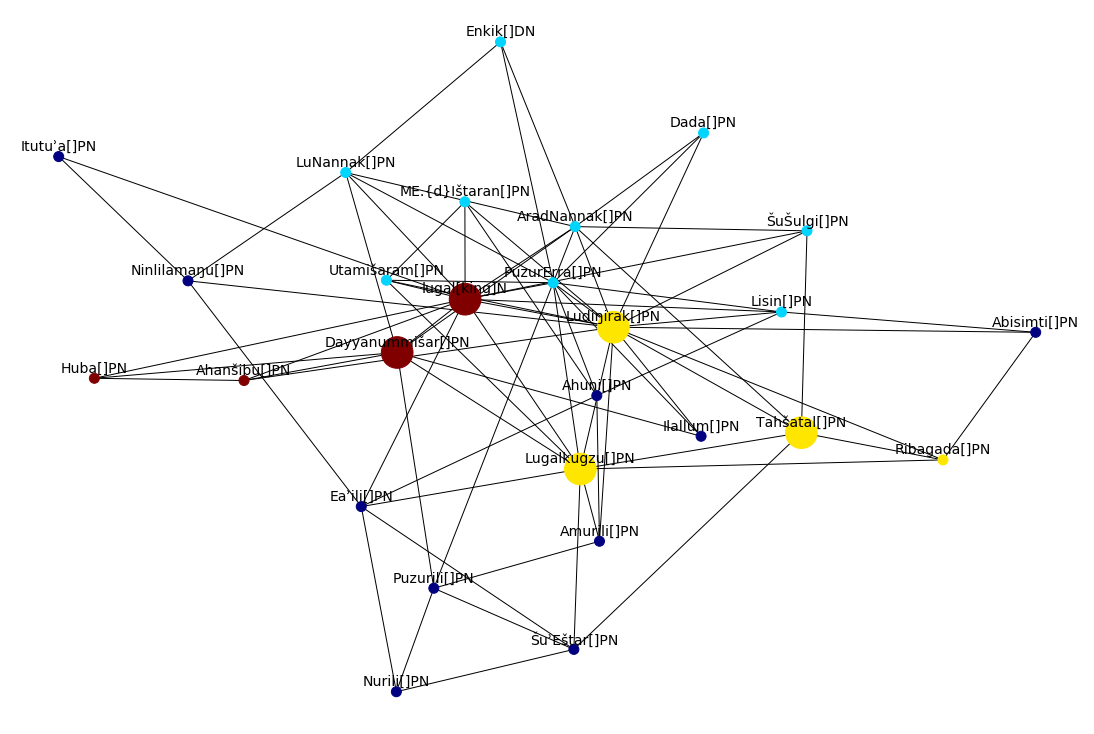

In [45]:
label_pos = {}
pos = nx.spring_layout(I)
for k, v in pos.items():
    label_pos[k] = (v[0], v[1]+0.03)
plt.figure(figsize=(15, 10))
plt.rcParams.update({'figure.figsize': (15, 10)})
nx.draw(
        I,
        pos=pos,
        node_color=colors,
        #edge_color=edge_color, 
        node_size = node_size, 
        with_labels = False,
        cmap= plt.cm.jet)
nx.draw_networkx_labels(I, label_pos, labels, font_size=14)
plt.show()

1


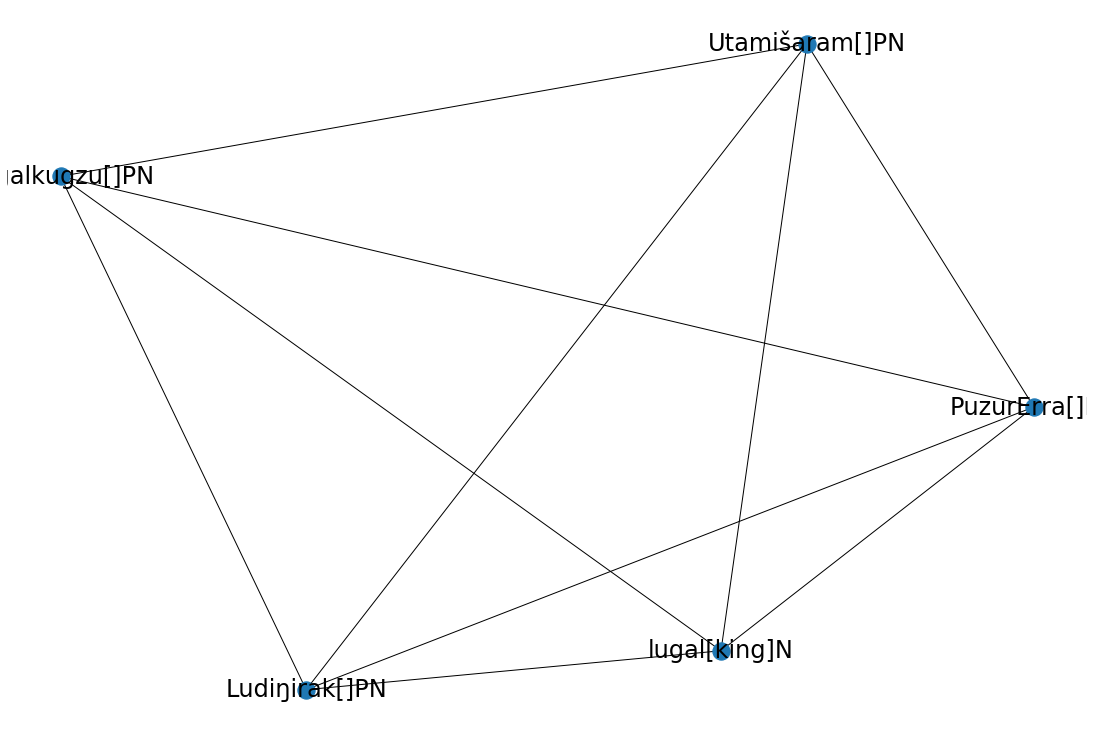

In [57]:
cliques = nx.find_cliques(H)
cliques4 = [clq for clq in cliques if len(clq) >= 5]
nodes = set(n for clq in cliques4 for n in clq)
print(len(cliques4))
h = H.subgraph(nodes)
nx.draw(h, with_labels=True, font_size = 24)
# from https://stackoverflow.com/questions/25222322/networkx-create-new-graph-of-all-nodes-that-are-a-part-of-4-node-clique

# Import Bokeh
The networkx module has facilities for displaying a network, but the options are limited. The Bokeh module has a much wider range of possibilities for drawing, inspecting, and exporting a network graph. The `from_networkx` function in Bokeh allows efficient import of nodes and edges.

In [47]:
from bokeh.io import output_file, show
from bokeh.models import (BoxSelectTool, Circle, EdgesAndLinkedNodes, HoverTool,
                          MultiLine, NodesAndLinkedEdges, Plot, Range1d, TapTool,
                         BoxZoomTool, ResetTool, OpenURL, CustomJS, Column, SaveTool)
from bokeh.palettes import Spectral4
from bokeh.plotting import figure, output_notebook
from bokeh.models.graphs import from_networkx
from bokeh.models import TextInput, Button
output_notebook()

Loading BokehJS ...

# Tooltips for Nodes
This graph provides tooltips for each node, containing the name and the degree. By computing other characteristics of the node, one may easily display other attributes in the tooltip. 

The edges are not displayed by default, but light up when the mouse hovers over a node.

In [48]:
plot = Plot(plot_width=900, plot_height=900,
            x_range=Range1d(-1.1, 1.1), y_range=Range1d(-1.1, 1.1))
plot.title.text = "Treasure Archive Drehem"

node_hover_tool = HoverTool(tooltips=[("name", "@name"), ("degree", "@degree")])
plot.add_tools(node_hover_tool, BoxZoomTool(), ResetTool())

graph_renderer = from_networkx(G, nx.spring_layout, scale=1, center=(0, 0))

graph_renderer.node_renderer.glyph = Circle(size='node_size', fill_color=Spectral4[0])
graph_renderer.edge_renderer.glyph = MultiLine(line_color=Spectral4[1], line_alpha=0.8, line_width=3)
plot.renderers.append(graph_renderer)

output_file("interactive_graphs.html")
show(plot)

In [49]:
plot = figure(plot_width=700, plot_height=700,
            x_range=Range1d(-1.1,1.1), y_range=Range1d(-1.1,1.1))

node_hover_tool = HoverTool(tooltips=[("name", "@name"), ("degree", "@degree")])
plot.add_tools(node_hover_tool)
plot.title.text = "Drehem Treasure Archive: the Nodes"

r = from_networkx(G, nx.circular_layout, scale=1, center=(0,0))

r.node_renderer.glyph = Circle(size='node_size', fill_color='#2b83ba')
r.node_renderer.hover_glyph = Circle(size='node_size', fill_color='#abdda4')

r.edge_renderer.glyph = MultiLine(line_alpha=0, line_width='weight')  # zero line alpha
r.edge_renderer.hover_glyph = MultiLine(line_color='#abdda4', line_width=5)

r.inspection_policy = NodesAndLinkedEdges()
plot.renderers.append(r)

show(plot)

In [50]:
plot = Plot(plot_width=1000, plot_height=900,
            x_range=Range1d(-2, 2), y_range=Range1d(-2, 2))
plot.title.text = "Drehem Treasure Archive"

graph_renderer = from_networkx(G, nx.circular_layout, scale=1.9, center=(0, 0))
#graph_renderer.edge_renderer.data_source.data["line_width"] = [G.get_edge_data(a,b)['weight'] for a, b in G.edges()]
#graph_renderer.edge_renderer.glyph.line_width = {'field': 'line_width'}
graph_renderer.edge_renderer.glyph.line_alpha = 0.8
graph_renderer.node_renderer.selection_glyph = Circle(size='degree', fill_color=Spectral4[2])
graph_renderer.node_renderer.hover_glyph = Circle(size='degree', fill_color=Spectral4[1])
graph_renderer.node_renderer.glyph = Circle(size='degree', fill_color=Spectral4[0])
graph_renderer.edge_renderer.glyph = MultiLine(line_color="#CCCCCC", line_alpha=0.8, line_width = 'weight')
graph_renderer.edge_renderer.selection_glyph = MultiLine(line_color=Spectral4[2], line_width = 'weight')
graph_renderer.edge_renderer.hover_glyph = MultiLine(line_color=Spectral4[1], line_width =  'weight')

graph_renderer.inspection_policy = NodesAndLinkedEdges()
graph_renderer.selection_policy = EdgesAndLinkedNodes()

node_hover_tool = HoverTool(tooltips=[("name", "@name"), ('degree', '@value')])
plot.renderers.append(graph_renderer)
plot.add_tools(node_hover_tool, BoxZoomTool(), ResetTool())
output_file("vis/interactive_graphs.html")
show(plot)

# Tooltips for Edges
The following code draws a network of the Drehem Treasure Archive. By selecting a node (click on the node) the node and all its direct neighbors are highlighted and the button below the drawing links to the collection of texts in ORACC from which these edges come.
# TODO
The list of P numbers is currently not unique - a P number may provide more than one relevant edge.

In [51]:
plot = Plot(plot_width = 900, plot_height = 900,
            x_range = Range1d(-1.1, 1.1), y_range = Range1d(-1.1, 1.1))
plot.title.text = "Drehem Treasure Archive"

plot.add_tools(HoverTool(tooltips = [('Text ID', '@id_text'), ('start', '@start'), ('end', '@end')]), 
               TapTool(), BoxSelectTool(), ResetTool(), BoxZoomTool(), SaveTool())

graph_renderer = from_networkx(G, nx.circular_layout, scale = 1, center = (0, 0))

graph_renderer.node_renderer.glyph = Circle(size = 'node_size', fill_color = Spectral4[0])
graph_renderer.node_renderer.selection_glyph = Circle(size = 'node_size', fill_color = Spectral4[2])
graph_renderer.node_renderer.hover_glyph = Circle(size = 'node_size', fill_color = Spectral4[1])

graph_renderer.edge_renderer.glyph = MultiLine(line_color = "#CCCCCC", line_alpha = 0.8, line_width = 5)
graph_renderer.edge_renderer.selection_glyph = MultiLine(line_color = Spectral4[2], line_width = 5)
graph_renderer.edge_renderer.hover_glyph = MultiLine(line_color = Spectral4[1], line_width = 5)

graph_renderer.selection_policy = NodesAndLinkedEdges()
graph_renderer.inspection_policy = EdgesAndLinkedNodes()

plot.renderers.append(graph_renderer)

info_text_ids = TextInput(title = 'Text IDs:', value = '')
info_start_end = TextInput(title = 'Start => End Values:', value = '')
url = "http://oracc.org/epsd2/admin/ur3/"
esource = graph_renderer.edge_renderer.data_source
code = """  start_end_values = []
            text_ids = []
            for(idx in esource.selected.indices)
            {
                index = esource.selected.indices[idx]
                start_end_values.push(esource.data['start'][index] + '=>' + esource.data['end'][index] ); 
                text_ids.push(esource.data['id_text'][index]) 
            }
            info_start_end.value = String(start_end_values);
            info_text_ids.value = String(text_ids);"""
code2 = """ urlnew = url.concat(info_text_ids.value);
            window.open(urlnew)"""
callback = CustomJS(args = dict(esource = esource, 
                                info_text_ids = info_text_ids, 
                                info_start_end = info_start_end), 
                    code = code)
plot.select_one(TapTool).callback = callback
button = Button(label="Click to open text editions", button_type="success")
button.js_on_click(CustomJS(args = dict(url=url, info_text_ids=info_text_ids), 
                        code=code2))
show(Column(plot, info_start_end, info_text_ids, button))